# Run Fine-Tuned Bert Model
This notebook demonstrates the inference pipeline for a fine-tuned BERT model developed for analyzing NEISS-related data. The model was trained in neiss_colab.ipynb with a focus on maximizing precision, and it is loaded directly from the Hugging Face Model Hub for efficient deployment.

In [ ]:
# Core libraries for data handling and manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# Scikit-learn metrics for evaluating classification performance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Hugging Face datasets and transformers for model training and evaluation
from datasets import Dataset, ClassLabel, Features, Value
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from huggingface_hub import notebook_login

# PyTorch for model definition and GPU acceleration
import torch
from torch.utils.data import DataLoader

In [26]:
df_list = []
for year in range(2014, 2024):
    path = f'./data/neiss{year}.tsv'
    print(path, '...', sep='')
    try:
        df_list.append(pd.read_csv(path, sep='\t'))
    except UnicodeDecodeError:
        print('Exception Caught')
        print(path, '...', sep='')
        print(len(pd.read_csv(path, sep='\t', encoding='ISO-8859-1')))
        df_list.append(pd.read_csv(path, sep='\t', encoding='ISO-8859-1'))
df = pd.concat(df_list, axis=0, ignore_index=True)

./data/neiss2014.tsv...
./data/neiss2015.tsv...
./data/neiss2016.tsv...
./data/neiss2017.tsv...
Exception Caught
./data/neiss2017.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_88571/927198845.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  print(len(pd.read_csv(path, sep='\t', encoding='ISO-8859-1')))


386907


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_88571/927198845.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t', encoding='ISO-8859-1'))


./data/neiss2018.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_88571/927198845.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t'))


./data/neiss2019.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_88571/927198845.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t'))


./data/neiss2020.tsv...
./data/neiss2021.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_88571/927198845.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t'))


./data/neiss2022.tsv...
./data/neiss2023.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_88571/927198845.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t'))


In [3]:
df.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,Body_Part_2,Diagnosis_2,Other_Diagnosis_2,Disposition,Location,Fire_Involvement,Product_1,Product_2,Product_3,Alcohol,Drug,Narrative_1,Stratum,PSU,Weight
0,140103999.0,01/01/2014,32,1.0,1.0,NaN,NaN,31.0,53.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1211.0,0.0,0.0,NaN,NaN,32 YOM CO PAIN IN THE CHEST AFTER FALLING WHIL...,S,98.0,80.0213
1,140104001.0,01/01/2014,18,1.0,1.0,NaN,NaN,82.0,51.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,910.0,0.0,0.0,NaN,NaN,18 YOM BURNED LT HAND WHILE POURING GASOLINE O...,S,98.0,80.0213
2,140104003.0,01/01/2014,31,2.0,1.0,NaN,NaN,37.0,64.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1807.0,0.0,0.0,NaN,NaN,31 YOF STATES SHE FELL THROUGH THE BATHROOM FL...,S,98.0,80.0213
3,140104670.0,01/01/2014,53,2.0,1.0,NaN,NaN,82.0,59.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,478.0,0.0,0.0,NaN,NaN,"53YOF WASHING DISHES AT HOME, A GLASS BROKE AN...",S,29.0,80.0213
4,140104672.0,01/01/2014,23,1.0,1.0,NaN,NaN,30.0,57.0,NaN,NaN,NaN,NaN,1.0,9.0,0.0,3286.0,0.0,0.0,NaN,NaN,"23YOM RIDING AN ATV, ROLLED OVER, HURT SHOULDE...",S,29.0,80.0213


In [4]:
len(df)

3520522

In [5]:
# Drop records with missing Narrative_1 data
df.drop(df[df['Narrative_1'].isnull()].index, axis=0, inplace=True)

In [6]:
# Reading in the pre-labeled data
labeled_df = pd.read_csv("./data/hand_labeled_samples_487.csv")

In [7]:
labeled_df.head()

,Narrative_1,Human Label,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,Body_Part_2,Diagnosis_2,Other_Diagnosis_2,Disposition,Location,Fire_Involvement,Product_1,Product_2,Product_3,Alcohol,Drug,Stratum,PSU,Weight
0,16YOM PRESENTS AFTER BEING PEDESTRIAN STRUCK W...,0,201227717.0,10/06/2020,16,1.0,1.0,NaN,2.0,87.0,71.0,NS,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,0.0,0.0,V,57.0,15.9992
1,55 YOM DX NECK AND BACK PAIN - S/P PT PEDESTRI...,0,160206064.0,01/04/2016,55,1.0,2.0,NaN,NaN,89.0,71.0,NECK/BACK PAIN,NaN,NaN,NaN,1.0,4.0,0.0,1329.0,0.0,0.0,NaN,NaN,V,57.0,16.1154
2,23YOM WITH ELBOW PAIN AFTER RIDING MOPED TO WO...,0,231242909.0,12/13/2023,23,1.0,2.0,NaN,2.0,32.0,57.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,3215.0,0.0,0.0,0.0,0.0,L,51.0,55.4417
3,50YOM W/THORACIC & LUMBAR BACK STRAIN S/P PEDE...,1,160333168.0,02/05/2016,50,1.0,0.0,NaN,NaN,31.0,64.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1684.0,0.0,0.0,NaN,NaN,V,41.0,15.3480
4,^66YOM PEDESTRIAN WHO JUMPED TO GET OUT OF WAY...,0,151107022.0,09/05/2015,66,1.0,0.0,NaN,NaN,37.0,71.0,PAIN,NaN,NaN,NaN,1.0,4.0,0.0,1871.0,0.0,0.0,NaN,NaN,V,41.0,15.7762


In [8]:
# Function to concatentate all useful information along with the narrative
def concat_narrative(row):
  body_part = row['Body_Part']
  diagnosis = row['Diagnosis']
  disposition = row['Disposition']
  product = row['Product_1']
  narrative = row['Narrative_1']

  return f"Product Code: {product}. Body Part Code: {body_part}. Diagnosis Code: {diagnosis}. Disposition Code: {disposition}. Narrative: {narrative}"

In [9]:
labeled_df['concat_narrative'] = labeled_df.apply(concat_narrative, axis=1)
labeled_df['concat_narrative']

0      Product Code: 5040.0. Body Part Code: 87.0. Di...
1      Product Code: 1329.0. Body Part Code: 89.0. Di...
2      Product Code: 3215.0. Body Part Code: 32.0. Di...
3      Product Code: 1684.0. Body Part Code: 31.0. Di...
4      Product Code: 1871.0. Body Part Code: 37.0. Di...
                             ...                        
482    Product Code: 1333.0. Body Part Code: 79.0. Di...
483    Product Code: 1744.0. Body Part Code: 87.0. Di...
484    Product Code: 5024.0. Body Part Code: 81.0. Di...
485    Product Code: 5022.0. Body Part Code: 35.0. Di...
486    Product Code: 1329.0. Body Part Code: 76.0. Di...
Name: concat_narrative, Length: 487, dtype: object

In [10]:
model = AutoModelForSequenceClassification.from_pretrained('DevJGraham/neiss_clf_bert_uncased')

In [11]:
tokenizer = AutoTokenizer.from_pretrained('DevJGraham/neiss_clf_bert_uncased')

In [12]:
# This is the cell that is affected by the numpy downgrade. If you run into an issue here, restart your runtime session and run the cells in the notebook again

# In order to stratify by the labels, you must set them as features in the dataset
features = Features({
    'text': Value('string'),
    'labels': ClassLabel(names=["Not Pedestrian", "Pedestrian"])
})

# Create a huggingface dataset only containing the text (concat_narrative) and the labels (Human Label)
dataset = Dataset.from_pandas(
    df=labeled_df.rename(columns={'concat_narrative':'text', 'Human Label': 'labels'}).reset_index(drop=True)[['labels','text']],
    features=features
)

# Split the data into a train and validation set, stratifying by the labels
dataset = dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column='labels')

In [13]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize(sample):
    return tokenizer(
        sample['text'],
        truncation=True
    )

results = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/389 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

In [22]:
# Set the model to evaluation mode (disables dropout and gradient tracking for layers that behave differently during training)
model.eval()

# Move the model to Compute Unified Device Architecture (cuda), a parallel computing platform and application programming interface (API) model created by NVIDIA
model.to('cpu')

# Loading the data to be batched and collated the same way during eval as it was during training
train_loader = DataLoader(
    results['test'].remove_columns(['text']),
    batch_size=8,
    collate_fn=data_collator
)

all_preds = []
all_labels = []

with torch.no_grad(): # Does not track gradients for evaluation
  for batch in train_loader:
    # Move each tensor in the batch to the GPU
    batch = {k: v.to('cpu') for k, v in batch.items()}
    
    # Run the model forward pass and get output logits
    outputs = model(**batch)
    
    # Select the index of the highest logit as the predicted class
    preds = torch.argmax(outputs.logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(all_labels, all_preds, digits=3))

              precision    recall  f1-score   support

           0      0.949     0.902     0.925        41
           1      0.932     0.965     0.948        57

    accuracy                          0.939        98
   macro avg      0.940     0.934     0.937        98
weighted avg      0.939     0.939     0.939        98



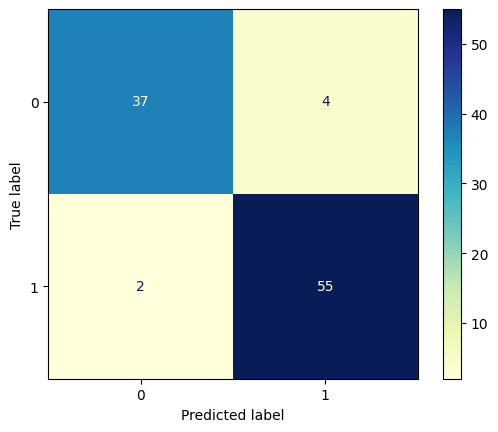

In [25]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(all_labels, all_preds))
cm_display.plot(cmap='YlGnBu')
plt.show()